In [403]:
# Testing Pacman
import postprocess as pp
import plots as plots
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline

from pathlib import Path 

In [404]:
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)


## Analyis helps

In [405]:
def _critical_load(matpar):
    _mu, _k, _w1, _N = matpar["mu"], matpar["k"], matpar["w1"], matpar["N"]
    return np.sqrt(8*_w1 / (_mu*_k)/4)
    # independent of _N**2


def _homogeneous_state(t, matpar):
    """docstring for _homogeneous_state"""
    _mu, _k, _w1, _N = matpar["mu"], matpar["k"], matpar["w1"], matpar["N"]


    # _tc = np.sqrt(matpar/k)
    # _a = (tau - 1) / (_k - 1)

    _tc = _critical_load(params["model"])
    _uh = [0 for i in range(0, _N+1)]
    
    if t <= _tc:
        # elastic
        _alphah = [0. for i in range(0, _N)]
        _uh = [i*t/_N for i in range(0, _N+1)]
    else:   
        # damaging
        _α = (t/_tc - 1) / (_k - 1)
        _alphah = [_α for i in range(0, _N)]

        # _S = reduce(lambda a, b: a+b, list(map(a_atk, _alphah)))
        
        _S = _N*a_atk(_α)

        _e = t / _N
        for i in range(0, _N+1):
            if i == 0:
                _uh[i] = 0
            else: 
                _uh[i] = _e * i
        # _uh = [a_atk(_α) / (_N*a_atk(_α)) * i/_N for i in range(0, _N+1)]
        # print(t, _e)
    return _alphah, _uh

In [727]:
class DefaultDamage:
    def __init__(self, state, matpar, name = "Default damage model: atk aka JJK aka LS"):
        self.state = state
        self.matpar = matpar
        self.str = name

    def _a(self, α):
        _α = self.state[α]
        # _α = α
        # _E0 = self.matpar[E0]
        _k = self.matpar[k]

        return (1 - α) / ((_k-1) * α + 1)

    def _w(self, _α):
        _α = α
        # _w1 = self.matpar[w1]

        return _α

    def energy(self, state):
        """Total energy"""
        return self._elastic(state) + self._damage(state) - self.work(state)

    def work(self, state):
        return 0

    def _elastic(self, state):
        _E0 = self.matpar[E0]
        _u = state[u]
        _α = state[α]

        return 1./2. * _E0 * self._a(_α) * sp.diff(_u, x)**2 

    def _damage(self, state):
        _α = state[α]
        _w1 = matpar[w1]
        _η = matpar[η]

        return _w1 * (self._w(_α) + matpar[η]**2 * (sp.diff(_α, x))**2 )


    def __str__(self):
     return self.str


class DamageATSN(DefaultDamage):
    """docstring for Model"""
    def __init__(self, state, matpar, name = "ATk Damage Model, Seb Neukirch"):
        super(DefaultDamage, self).__init__(matpar, name = name)

    def _a(self, state):
        α = state[α]
        _E0 = self.matpar[E0]

        # return (1 - α)**2

    def _w(self, _α):
        _α = α
        _n = self.matpar[n]
        return 1-(1.-_α)**2


class DamageATn(DefaultDamage):
    """docstring for Model"""
    def __init__(self, state, matpar, name = "ATn Damage Model"):
        super(DamageATn, self).__init__(state, matpar, name = name)

    def _a(self, α):
        return (1 - α)**2

    def _w(self, _α):
        _α = α
        _n = self.matpar[n]
        return _α**_n


class DamagePQ(DefaultDamage):
    """Particularly interesting model, as per marigo-2012"""
    def __init__(self, state, matpar = None, name = "PQ Damage Model"):
        if matpar == {}:
            if matpar is None:
                p, q, E0, L, w1, η, σc = sp.symbols('p q E0 L w1 η σc')
                matpar = {p: p, q: q, E0: E0, w1: w1, η: η, L: L, σc: σc}

            self.matpar = matpar
            # TODO: fix redundancies, like below
            # self.matpar = _matpar

        super(DamagePQ, self).__init__(state, matpar, name = "PQ Damage Model")

    def _a(self, α):
        _q = self.matpar[q]
        _p = self.matpar[p]

        return (1 - α)**_q / (1 + α)**_p  

    def _w(self, _α):
        
        
        _α = α
        _q = self.matpar[q]
        _p = self.matpar[p]
        _σc = self.matpar[σc]
        _E0 = self.matpar[E0]

        return (_p+_q) * _α * _σc**2 / _E0


class DamagePQ2(DefaultDamage):
    """Particularly interesting other model, as per marigo-2012, 
        Requires: q > p > 0
    """
    def __init__(self, state, matpar = {}, name = "PQ Damage Model"):
        if matpar == {}:
            p, q, E0, L, w1, η, σc = sp.symbols('p q E0 L w1 η σc')
            _matpar = {p: p, q: q, E0: E0, w1: w1, η: η, L: L, σc: σc}
            self._matpar = _matpar
            # TODO: fix redundancies, like below
            # self.matpar = _matpar

        super(DamagePQ, self).__init__(state, _matpar, name = "PQ Damage Model")

    def _a(self, α):
        _q = self._matpar[q]
        _p = self._matpar[p]

        return (1 - α)**_q 

    def _w(self, _α):
        
        _α = α
        _q = self._matpar[q]
        _p = self._matpar[p]
        _σc = self._matpar[σc]
        _E0 = self._matpar[E0]

        return _q * _σc**2 / (2.* _p * _E0)  * (1.-(1.-_α)**_p)


class PerfectBrittle(DefaultDamage):
    """Perfectly brittle model, as per marigo-2012, 
        w'/E' is constant
    """
    def __init__(self, state, matpar = {}, name = "PQ Damage Model"):
        if matpar == {}:
            p, q, E0, L, w1, η, σc = sp.symbols('p q E0 L w1 η σc')
            _matpar = {p: p, q: q, E0: E0, w1: w1, η: η, L: L, σc: σc}
            self._matpar = _matpar
            # TODO: fix redundancies, like below
            # self.matpar = _matpar

        super(DamagePQ, self).__init__(state, _matpar, name = "PQ Damage Model")

    def _a(self, α):
        _q = self._matpar[q]
        _p = self._matpar[p]

        # return (1 - α)**_q 
        # return ?

    def _w(self, _α):
        
        _α = α
        _σc = self._matpar[σc]
        _E0 = self._matpar[E0]
        _ec = _σc / _E0

        return _E0 * (1 - self._a) * _ec**2 /2.


In [551]:
## Simple Analytic 
# import visuals
E0, L, w1, η, σc = sp.symbols('E0 L w1 η σc')
# k = sp.symbols('k', integer = True)
x, t = sp.symbols('x t')
α = sp.Function('α')(x)
u = sp.Function('u')(x)


### Homogeneous sound solution
<!-- u = tx -->
<!-- alpha = 0 -->

In [791]:
class ModelAnalysis:
    """Helper class to analyse stability properties of a model"""

    def __init__(self, model):
        self.model = model
        self.state = model.state
        self.matpar = model.matpar

        self._s = 1/self.model._a(state[α])
        self._sp = sp.diff(self._s, state[α], 1)
        self._spp = sp.diff(self._s, state[α], 2)

        self._a = self.model._a(state[α])
        self._ap = sp.diff(self._a, state[α], 1)
        self._app = sp.diff(self._a, state[α], 2)

        self._w = self.model._w(state[α])
        self._wp = sp.diff(self._w, state[α])
        self._wpp = sp.diff(self._w, state[α], 2)

    def criterion(self):
        """Damage onset"""
        model, state = self.model, self.state

        _u0 = t*x/L
        _alpha0 = 0

        _crit = sp.diff(model.energy(state), α) \
            .subs({u: _u0, α: _alpha0})         \
            .simplify()
        # .subs(matpar).simplify()
        # _ts = np.array(sp.solve(_crit, t))
        # return np.where(_ts > 0)
        self.crit = _crit

        return _crit

    def _homogeneous_energy(self, _matpar):
        state, (_uf, _af) = self._homogeneous_state(_matpar)

        _u = state[0]
        _alpha = state[1]

        return

    def critical_load(self):
        ans = sp.solve(self.crit, t)
        _ = [t.subs(_matpar) for t in ans]
        positive = np.where(np.array(_) > 0)[0][0]
        # pdx
        self._critical_load = ans[positive]
        return ans[positive]

    def critical_load_N(self, _matpar={}):
        return np.float64(self._critical_load.subs(_matpar))

    def set_critical_load(self, _critical_load):
        self._critical_load = _critical_load

    def _check_constitutive(self):
        _a = 1
        # a -> E(a) decreasing
        # a -> w(a) increasing
        # a -> -w'/E' increasing
        # a -> -w'/s' decreasing
        return

    def _homogeneous_alpha(self, matpar = None):
        _u0 = t*x/L

        if matpar is not None:
            _matpar = matpar
        else:
            _matpar = self.matpar

        try:
            _eq = sp.diff(self.model.energy(state), α) \
                .subs({u: _u0, α: α})         \
                .simplify()

            _ah = sp.solve(_eq, α)

        # except NotImplementedError as e:
        except:
            _eq = sp.diff(ana.model.energy(state), α)   \
                .subs({u: _u0, α: α})                   \
                .subs(_matpar)                   \
                .simplify()

            _ah = sp.solve(_eq, α)

        return _ah

    def plot_homogeneous_alpha(self, _matpar={}):
        ah = self._homogeneous_alpha()
        _tc = self.critical_load_N(_matpar)

        fig, axis = plt.subplots(1, 1, figsize=(8, 6))

        # Plot the zero range
        subcritical_times = np.linspace(0., _tc)
        axis.plot(subcritical_times, [0 for t in subcritical_times], c="C0")

        supercritical_times = np.linspace(_tc, 3)

        for _a in ah:
            _af = sp.lambdify(t, _a.subs(_matpar), "numpy")

            axis.plot(supercritical_times, [_af(t)
                      for t in supercritical_times], c="C0")
            # plt.plot()

        axis.set_xlim(0, 3)
        axis.set_ylim(0, 1)

        plt.axvline(_tc, c='k')
        plt.axhline(1, c='k')

        return fig, axis

    def plot_homogeneous_stress(self, _matpar={}, ah=None):
        ah = self._homogeneous_alpha()
        # _tc = self.critical_load_N(_matpar)
        try:
            _tc = self.critical_load_N(_matpar)
        except:
            _tc = self._critical_load
        print(f"_tc {_tc}")
        fig, axis = plt.subplots(1, 1, figsize=(8, 6))

        # Plot the zero range
        times = np.linspace(0, 3, 30)

        _sf = sp.lambdify(t, self._stress(ah=ah).subs(_matpar), "numpy")

        # axis.plot(np.linspace(0, 3), [_sf(t) for t in times], c="C0")
        axis.plot(_times, [_sf(t) for t in _times], c="C0")

        plt.axvline(_tc, c='k')
        plt.axhline(1, c='k')

        axis.set_xlim(0, 3)
        axis.set_ylim(0, 1)

        return fig, axis

    def _homogeneous_state(self, _matpar={}, ah=None):
        if ah is None:
            # Good luck with the first solution
            _ah = self._homogeneous_alpha()[0]
        else:
            _ah = ah
        try:
            _tc = self.critical_load_N(_matpar)
        except:
            _tc = self._critical_load

        x, t = sp.symbols('x t')
        print(_tc)
        _homogeneous_alpha = sp.Piecewise((_ah, t >= _tc), (0, t < _tc))
        _homogeneous_u = t * x / L

        _uf = sp.lambdify((t, x), _homogeneous_u.subs(_matpar), "numpy")
        _af = sp.lambdify(t, _homogeneous_alpha.subs(_matpar), "numpy")

        state = {u: _homogeneous_u, α: _homogeneous_alpha}

        return state, (_uf, _af)

    def _set_homogeneous_alpha(self, ah):
        self._alpha_h = ah

        return

    def plot_homogeneous_energies(self, _matpar):

        _homog_state, (_uf, _af) = self._homogeneous_state(_matpar)

        _en_h = sp.lambdify(t, at1.energy(_homog_state).subs(
            {α: _homog_state[1]}).subs(_matpar), "numpy")
        _en_dam_h = sp.lambdify(t, at1._damage(_homog_state).subs(
            {α: _homog_state[1]}).subs(_matpar), "numpy")
        _en_ela_h = sp.lambdify(t, at1._elastic(_homog_state).subs(
            {α: _homog_state[1]}).subs(_matpar), "numpy")
        fig, axis = plt.subplots(1, 1, figsize=(8, 6))

        plt.plot(np.linspace(0., 3.), [_en_h(t)
                 for t in np.linspace(0., 3.)], c="C0")
        plt.plot(np.linspace(0., 3.), [_en_dam_h(t)
                 for t in np.linspace(0., 3.)], c="C1")
        plt.plot(np.linspace(0., 3.), [_en_ela_h(t)
                 for t in np.linspace(0., 3.)], c="C2")

        return fig, axis

    def plot_material(self):
        _damage = np.linspace(0., 1.)

        _af = sp.lambdify(α, self._a.simplify().subs(_matpar), "numpy")
        _apf = sp.lambdify(α, self._ap.simplify().subs(_matpar), "numpy")
        _appf = sp.lambdify(α, self._app.simplify().subs(_matpar), "numpy")

        # _apf = sp.lambdify(t, ana.)ap.subs(_matpar), "numpy")
        # _apf

        figure, axis = plt.subplots(1, 2, figsize=(8, 6))
        _ax = axis[0]
        _ax.axhline(0, c='k')
        _ax.plot(_damage, [_af(α) for α in _damage], label="a")
        _ax.legend(loc=2)
        # _ax.twiny()
        _ax.plot(_damage, [_apf(α) for α in _damage], label="a'", c='r')
        _ax.plot(_damage, [_appf(α) for α in _damage], label="a''")
        _ax.set_xlim(0, 1)
        _ax.legend()

        _sf = sp.lambdify(α, self._s.simplify().subs(_matpar), "numpy")
        _spf = sp.lambdify(α, self._sp.simplify().subs(_matpar), "numpy")
        _sppf = sp.lambdify(α, self._spp.simplify().subs(_matpar), "numpy")

        _ax = axis[1]

        _ax.plot(_damage, [_sf(α) for α in _damage], label="s")
        _ax.legend(loc=2)
        _ax.axhline(0, c='k')
        _ax.twinx()
        _ax.plot(_damage, [_spf(α) for α in _damage], label="s'")
        _ax.plot(_damage, [_sppf(α) for α in _damage], label="s''")
        _ax.set_xlim(0, 1)
        _ax.set_ylim(0, 10)
        _ax.legend(loc=1)
        figure.suptitle(f"Behaviour of {self.model.__str__()} is Material")

        return figure, axis

    def _hypotheses1(self):
        """As per marigo-2012, HP1: w'/S' decreasing wrt alpha"""

        _hp1 = self._sp / self._wp
        return _hp1

    def _H_damage_profile(self):
        """A function of sigma and beta constructs localisation profiles"""
        _σ = sp.symbols('σ')
        _β = sp.symbols('β')

        _Hf = 1/E0*(2*ana._w - _σ**2 * (ana._s - 1/E0)).subs({α: _β})
        # _spf = sp.lambdify(α, self._sp.simplify().subs(_matpar), "numpy")

        # ana._H_damage_profile().subs(_matpar).subs({α: _β})
        return _Hf

    def _α_max(self, σ, matpar = None):
        _β = sp.symbols('β')
        _σ = sp.symbols('σ')
        # _matpar = self.matpar
        _Hσβ = self._H_damage_profile().subs(matpar)

        _Hβ = _Hσβ.subs({_σ: σ})
        _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect')
        print(_sol)
        αmax = np.float64(_sol[1][0])

        return αmax

    def _stress(self, ah=None):
        _homog_state, (_uf, _af) = self._homogeneous_state(_matpar, ah=ah)

        _ah = _homog_state[α]

        _tc = self.critical_load_N(_matpar)

        stress_alpha = sp.Piecewise(
            (sp.sqrt(2 * self._wp / self._sp).subs({α: _ah}), t >= _tc),
            # sigma = E(alpha=0) u'
            (sp.diff(_homog_state[u], x).subs(_matpar), t < _tc))

        # return sp.sqrt( 2* self._wp / self._sp).subs({α: _ah})
        return stress_alpha

    def _Dσ(self, σ):
        """Half length of the localisation as a function of σ"""
        _αh = self._homogeneous_alpha()
        _β = sp.symbols('β')
        _αmax = self._α_max(σ)

        _E0 = self.model._matpar[E0]
        _η = self.model._matpar[η]

        _f = 1/self._H_damage_profile()

        _Dσ = _η * sp.integrate(_f, (_β, 0, _αmax))

    def _Dc(self):
        """Half length of the localisation at the onset"""
        _αh = self._homogeneous_alpha()
        _E0 = self.model._matpar[E0]
        _D = np.pi * η * \
            sp.sqrt(2 * _E0 / (σ * self._spp - 2.*self._wpp)).subs({α: 0})

    def _deps_1_d_dσ(self):
        _α = self.model.state[α]
        _E0 = self.model.matpar[E0]
        # _σc = self.model.matpar[σc]
        _σc = 1.

        _sp = self._sp
        _w = self._w

        return - ((np.pi * 2**(5/2) * ((_sp))**2 * _σc**2 * _E0**1/2) /
                  (self._spp * _σc**2 - 2. * self._wpp) ** (3/2)).subs({α: 0})

    # check: dependence of localisation zone wrt stress
    # check: global maccro response


In [477]:
E0, L, w1, η, σc = sp.symbols('E0 L w1 η σc')
k = sp.symbols('k', integer = True)

x, t = sp.symbols('x t')
α = sp.Function('α')(x)
u = sp.Function('u')(x)

state = {u: u, α: α}

# sp.diff(atk.elastic(state), α).subs({u: _u0}).simplify()



In [478]:
# _times = np.linspace(0., atk.matpar)
_times = np.linspace(0., 3.)
_damage = np.linspace(0., 1.)


## ATk

In [504]:
state = {u: u, α: α}
_matpar = {k: 2, E0: 1, w1: 1, η: η, L: 1}
matpar = {k: k, E0: 1, w1: w1, η: η, L: L}

_u0 = t*x/L
_alpha0 = 0 

atk = DefaultDamage(state, _matpar)


ana = ModelAnalysis(atk)
_crit = sp.diff(atk.energy(state), α).subs({u: _u0, α: _alpha0}).simplify()
_crit




w1 - 1.0*t**2/L**2

In [480]:
print(atk)

Default damage model: atk aka JJK aka LS


In [481]:
# atk = DefaultDamage(state, matpar)
ana = ModelAnalysis(atk)
ana.criterion()


w1 - 1.0*t**2/L**2

In [482]:
sp.latex(_)

'\\frac{1.0 w_{1} α^{2}{\\left(x \\right)} + 2.0 w_{1} α{\\left(x \\right)} + 1.0 w_{1} - \\frac{1.0 t^{2}}{L^{2}}}{1.0 α^{2}{\\left(x \\right)} + 2.0 α{\\left(x \\right)} + 1.0}'

In [483]:
ana.crit
ana.critical_load()
# _crits = sp.solve(t**2 - ana.critical_load()[t**2], t)
# sp.solve(t**2 - ana.critical_load()[0]*t**2, t)
_ = sp.solve(t**2 - ana.critical_load()[0], t)


In [484]:
sp.latex(_)

'\\left[ - L \\sqrt{w_{1}}, \\  L \\sqrt{w_{1}}\\right]'

In [485]:
ana.critical_load()


[L**2*w1]

In [486]:
ana.critical_load_N(_matpar)[0][0]

1

In [487]:
ana.set_critical_load(ana.critical_load_N(_matpar)[0][0])
# ana._critical_load

In [488]:
_ = sp.diff(atk.energy(state), α) \
    .subs({u: _u0, α: α}) \
    .simplify()

In [489]:
_
# sp.latex(_)

(1.0*w1*α(x)**2 + 2.0*w1*α(x) + 1.0*w1 - 1.0*t**2/L**2)/(1.0*α(x)**2 + 2.0*α(x) + 1.0)

In [490]:
ana._homogeneous_state(ah = ana._homogeneous_alpha()[1])

1


({u(x): t*x/L, α(x): Piecewise((-1.0 + t/(L*sqrt(w1)), t >= 1), (0, True))},
 (<function _lambdifygenerated(t, x)>, <function _lambdifygenerated(t)>))

(0.0, 2.0)

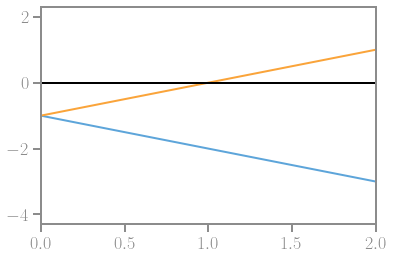

In [491]:
_eq = sp.diff(atk.energy(state), α) \
    .subs({u: _u0, α: α}) \
    .simplify()

_ah = sp.solve(_eq, α)


_ah_f = [sp.lambdify(t, a.subs(_matpar), "numpy") for a in _ah]

# _ahp = sp.lambdify(t, _ah_sub[0].subs(_matpar), "numpy")

_times = np.linspace(0., 3)

for _a in _ah_f:
    plt.plot(_times, [_a(t) for t in _times])

plt.axhline(0, c='k')
plt.xlim(0, _matpar[k])
# plt.plot()

### Check if multiple solutions

In [492]:
state, (_uf, _af) = ana._homogeneous_state(ah = ana._homogeneous_alpha()[1])

1


In [493]:
_a = state[α]

_ah_f = sp.lambdify(t, _a.subs(ana.model.matpar), "numpy")
_ah_f(0)

array(0.)

In [498]:
print(ana.model)

Default damage model: atk aka JJK aka LS


Text(0.5, 1.0, 'Default damage model: atk aka JJK aka LS')

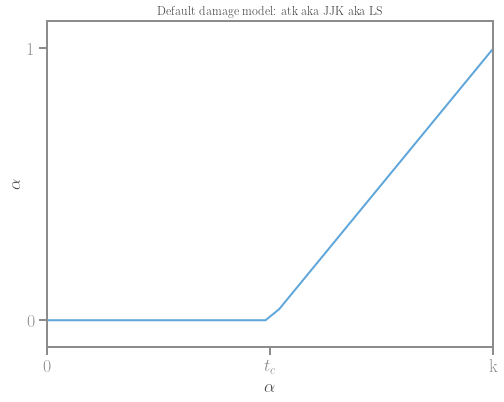

In [499]:
fig, axis = plt.subplots(1, 1, figsize=(8, 6))

axis.plot(_times, [_ah_f(t) for t in _times])
tc = ana.critical_load()[0].subs(ana.model.matpar)

# axis.axhline(0, c='k')
axis.set_xlim(0, _matpar[k])
axis.set_ylim(-0.1, 1.1)
axis.set_xticks([0, tc, _matpar[k]], ["0", "$t_c$", "k"])
axis.set_yticks([0, 1], ["0", "1"])
axis.set_xlabel("$\\alpha$")
axis.set_ylabel("$\\alpha$")
axis.set_title(f"{ana.model}")


In [500]:
fig.tight_layout()
fig.savefig("../../notes/figures/atk-alpha-homog.pdf")

In [501]:
atk.energy({u: _homog_state[u], α: _homog_state[α]})

KeyError: Piecewise((-1.0 + t/(L*sqrt(w1)), t >= 1), (0, True))

In [78]:
_en_h = sp.lambdify(t, atk.energy(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")
_en_dam_h = sp.lambdify(t, atk._damage(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")
_en_ela_h = sp.lambdify(t, atk._elastic(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")

plt.plot(np.linspace(0., 3.), [_en_h(t) for t in np.linspace(0., 3.)], c="C0")
plt.plot(np.linspace(0., 3.), [_en_dam_h(t) for t in np.linspace(0., 3.)], c="C1")
plt.plot(np.linspace(0., 3.), [_en_ela_h(t) for t in np.linspace(0., 3.)], c="C2")


KeyError: Piecewise(((-L*w1 - 0.707106781186548*t*sqrt(k*w1))/(L*w1*(k - 1.0)), t >= 1), (0, True))

<lambdifygenerated-227>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (-_Dummy_7888 - 1)/(_Dummy_7888 - 1)
<lambdifygenerated-228>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2/(_Dummy_7889 - 1)**2
<lambdifygenerated-229>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return -4/(_Dummy_7890 - 1)**3


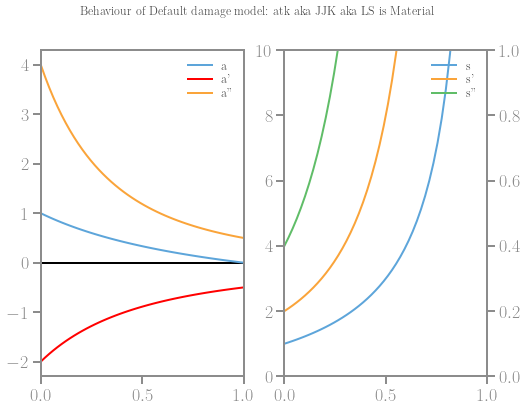

In [505]:
figure, axis = ana.plot_material()

In [507]:
figure.tight_layout()
figure.savefig("../../notes/figures/atk-model.pdf")

In [250]:
# Localised branches
ana._s, ana._sp.simplify(), ana._spp.simplify()

((α(x) + 1)/(1 - α(x)), 2/(α(x) - 1)**2, -4/(α(x) - 1)**3)

1


(0.0, 100.0)

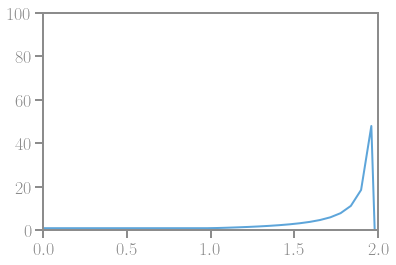

In [258]:
_homog_state, (_uf, _af) = ana._homogeneous_state(_matpar, ah = ana._homogeneous_alpha()[1])


_s = ana._s.subs({α: _homog_state[α]}).subs(_matpar)
_sf = sp.lambdify(t, _s, "numpy")

plt.plot(_times, [_sf(t) for t in _times], c="C0")
plt.xlim(0, _matpar[k])
plt.ylim(0, 100)


1


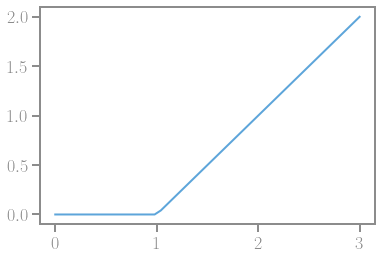

In [254]:
_homog_state, (_uf, _af) = ana._homogeneous_state(_matpar, ah = ana._homogeneous_alpha()[1])


_w = ana._w.subs({α: _homog_state[α]}).subs(_matpar)
_wf = sp.lambdify(t, _w, "numpy")

plt.plot(_times, [_wf(t) for t in _times], c="C0")


<lambdifygenerated-300>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.9801 - 0.9801*(β + 1)/(1 - β)
<lambdifygenerated-301>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.814004938271605 - 0.814004938271605*(β + 1)/(1 - β)
<lambdifygenerated-302>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.66331975308642 - 0.66331975308642*(β + 1)/(1 - β)
<lambdifygenerated-303>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.528044444444444 - 0.528044444444444*(β + 1)/(1 - β)
<lambdifygenerated-304>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.408179012345679 - 0.408179012345679*(β + 1)/(1 - β)
<lambdifygenerated-305>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.303723456790123 - 0.303723456790123*(β + 1)/(1 - β)
<lambdifygenerated-306>:2: RuntimeWarning: divide by zero encountered in double_sc

(-1.0, 1.0)

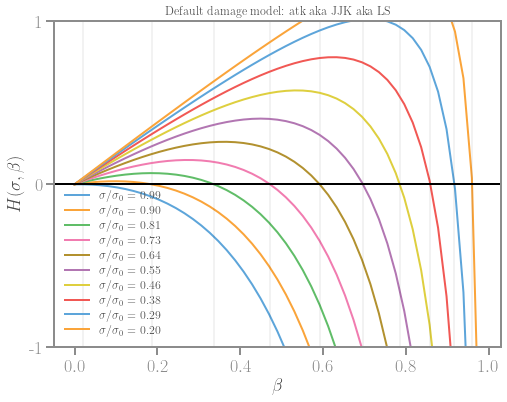

In [515]:
_Hσβ = ana._H_damage_profile().subs(_matpar)

_σ = sp.symbols('σ')
_β = sp.symbols('β')

figure, axis = plt.subplots(1, 1, figsize=(8, 6))


for k in np.linspace(.99, .2, 10):
# for k in np.arange(2, 5):
    _Hβ = _Hσβ.subs({_σ: k})
    # _Hβ = _Hσβ.subs({_σ: 1./k})
    _Hβf = sp.lambdify(_β, _Hβ, "numpy")
    _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect') 
    αmax = _sol[1][0]
    axis.plot(_damage, [_Hβf(β) for β in _damage], label = f"$\sigma/\sigma_0$  = {k:.2f}")
    # axis.plot(_damage, [_Hβf(β) for β in _damage], label = f"$\sigma/\sigma_0$  = 1/{k:d}")
    axis.axvline(αmax, c='k', lw=.1)



axis.set_ylabel("$H(\\sigma, \\beta)$")
axis.set_xlabel("$\\beta$")
axis.set_title(f"{ana.model}")
axis.legend()
axis.axhline(0, c="k")
axis.set_yticks([-1, 0, 1], ["-1", "0", "1"])
axis.set_ylim(-1, 1)


In [516]:
figure.tight_layout()
figure.savefig("../../notes/figures/atk-Hbeta.pdf")

In [517]:

def _amax_sigma(σv):
    _β = sp.symbols('β')
    _σ = sp.symbols('σ')
    _matpar = ana.model.matpar
    _Hσβ = ana._H_damage_profile().subs(_matpar)

    _Hβ = _Hσβ.subs({_σ: σv})
    _sol = sp.solve(_Hβ, _β, (0., 1), solver='bisect')
    # print(_sol)
    # print(_sol[1][0])
    
    αmax = np.float64(_sol[1][0])
    return αmax

In [291]:
_amax_sigma(.999)

# ana._α_max(1.)

0.001999

[(0.0, (0.0, 1.0)), (0.00133296299588935, (0.0, 1.0)), (1.49966653700411, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.143343227067318, (0.0, 1.0)), (1.46139748898206, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.276682482799598, (0.0, 1.0)), (1.41972388139793, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.401636264642337, (0.0, 1.0)), (1.37436017980211, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.518504627966867, (0.0, 1.0)), (1.32500632882326, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.627600938959682, (0.0, 1.0)), (1.27134896227489, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.729250331194344, (0.0, 1.0)), (1.21306294658343, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.823787846649758, (0.0, 1.0)), (1.14981323977000, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.911556295837192, (0.0, 1.0)), (1.08125703132330, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.992903887994099, (0.0, 1.0)), (1.00704611200590, (0.0, 1.0))]


Text(0.5, 1.0, 'Damage Model')

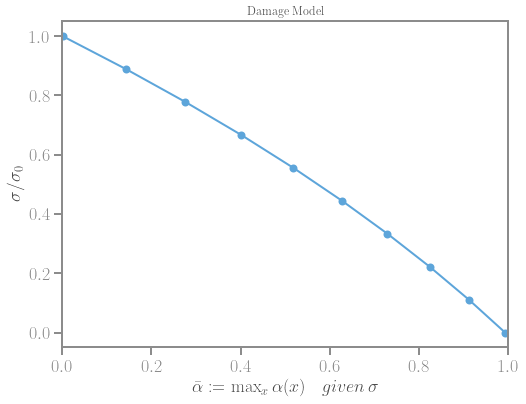

In [663]:

figure, axis = plt.subplots(1, 1, figsize=(8, 6))

amax = []
for i in np.linspace(.999, .01, 10):
    amax.append(ana._α_max(i, matpar))


axis.plot(amax, np.linspace(1, .0, 10), marker='o')
axis.set_xlabel('$\\bar \\alpha := \\max_x \\alpha(x) \\quad given\, \\sigma$')
axis.set_ylabel('$\\sigma/\\sigma_0$')
axis.set_xlim(0., 1.)
axis.set_title(f"{ana.model}")

# plt.plot(np.linspace(-.99, -.2, 10), amax)

In [530]:
figure.tight_layout()
figure.savefig("../../notes/figures/atk-maxalpha.pdf")

## ATn

In [621]:
## Simple Analytic 
# import visuals

E0, L, w1, η, σc = sp.symbols('E0 L w1 η σc')
x, t = sp.symbols('x t')
α = sp.Function('α')(x)
u = sp.Function('u')(x)

n = sp.symbols('n')


#### ATn, n=1 => AT1

In [670]:
state = {u: u, α: α}
matpar = {n: 1, E0: 1, w1: 1, η: η}
_matpar = {n: 1, L: 1, E0: 1, w1: 1, η: η}

at1 = DamageATn(state, matpar={n: 1, E0: E0, w1: w1, η: η, L: L}, name="At1 Damage Model")
ana = ModelAnalysis(model = at1)

_ = ana.criterion()
_
# ana.critical_load()
# ana._homogeneous_alpha()
print(ana.model)


At1 Damage Model


In [671]:
sp.latex(_)

'- \\frac{1.0 E_{0} t^{2}}{L^{2}} + 1'

In [672]:
_ = ana.model.energy(ana.model.state)
# , α) \
#     .subs({u: _u0, α: _alpha0})         \
#     .simplify()

In [673]:
# sp.solve(ana.crit, t)
_ = ana.critical_load()

In [674]:
_

L*sqrt(1/E0)

In [675]:
sp.latex(_)

'L \\sqrt{\\frac{1}{E_{0}}}'

In [676]:
ana.criterion()

-1.0*E0*t**2/L**2 + 1

In [677]:
ana._critical_load

L*sqrt(1/E0)

In [678]:
ana.critical_load_N(_matpar)

1.0

Text(0.5, 1.0, 'At1 Damage Model')

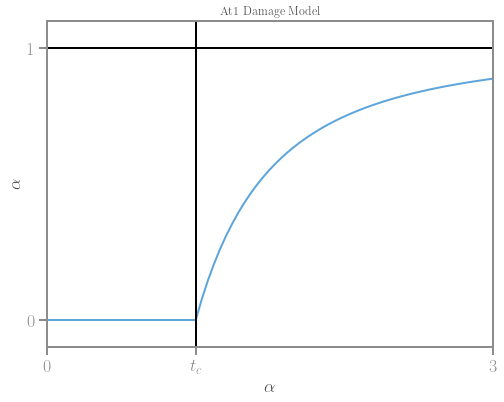

In [679]:

figure, axis = ana.plot_homogeneous_alpha(_matpar)
axis.set_ylim(-0.1, 1)

# axis.axhline(0, c='k')
axis.set_xlim(0, 3)
axis.set_ylim(-0.1, 1.1)
axis.set_xticks([0, tc, 3], ["0", "$t_c$", "3"])
axis.set_yticks([0, 1], ["0", "1"])
axis.set_xlabel("$\\alpha$")
axis.set_ylabel("$\\alpha$")
axis.set_title(f"{ana.model}")

In [680]:
figure.tight_layout()
figure.savefig("../../notes/figures/at1-alpha-homog.pdf")

_tc 1.0
1.0


TypeError: Argument must be a Basic object, not `list`

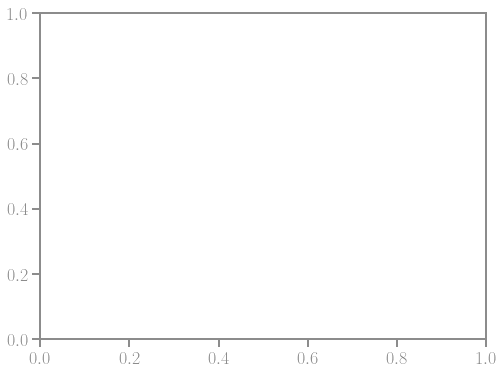

In [681]:

figure, axis = ana.plot_homogeneous_stress(_matpar)


# axis.axhline(0, c='k')
axis.set_xlim(0, 3)
axis.set_ylim(-0.1, 1.1)
axis.set_xticks([0, tc, 3], ["0", "$t_c$", "3"])
axis.set_yticks([0, 1], ["0", "1"])
axis.set_xlabel("$t$")
axis.set_ylabel("$\\sigma$")
axis.set_title(f"{ana.model}")

In [682]:
_homog_state, (_uf, _af) = ana._homogeneous_state(_matpar)
_ = _homog_state[α]


1.0


In [683]:
sp.latex(_)

'\\begin{cases} 1 - \\frac{L^{2}}{E_{0} t^{2}} & \\text{for}\\: t \\geq 1.0 \\\\0 & \\text{otherwise} \\end{cases}'

In [684]:
at1.energy({u: _homog_state[u], α: _homog_state[α]})

0.5*E0*t**2*(1 - Piecewise((1 - L**2/(E0*t**2), t >= 1.0), (0, True)))**2/L**2 + α(x)

<lambdifygenerated-381>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 0.5*t**2*(1 - select([greater_equal(t, 1.0),True], [1 - 1/t**2,0], default=nan))**2 + select([greater_equal(t, 1.0),True], [1 - 1/t**2,0], default=nan)
<lambdifygenerated-382>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return select([greater_equal(t, 1.0),True], [1 - 1/t**2,0], default=nan)
<lambdifygenerated-383>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 0.5*t**2*(1 - select([greater_equal(t, 1.0),True], [1 - 1/t**2,0], default=nan))**2


Text(0.5, 1.0, 'At1 Damage Model')

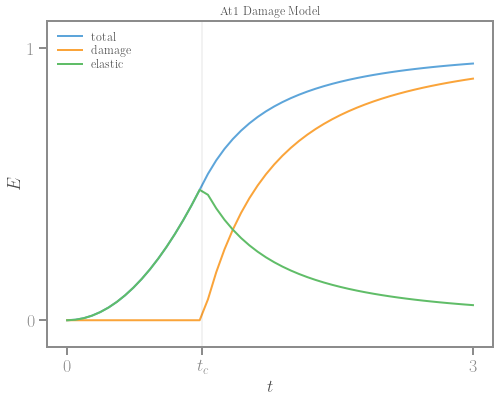

In [685]:

figure, axis = plt.subplots(1, 1, figsize=(8, 6))


_en_h = sp.lambdify(t, at1.energy(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")
_en_dam_h = sp.lambdify(t, at1._damage(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")
_en_ela_h = sp.lambdify(t, at1._elastic(_homog_state).subs({α: _homog_state[α]}).subs(_matpar), "numpy")

axis.plot(np.linspace(0., 3.), [_en_h(t) for t in np.linspace(0., 3.)], c="C0", label = "total")
axis.plot(np.linspace(0., 3.), [_en_dam_h(t) for t in np.linspace(0., 3.)], c="C1", label = "damage")
axis.plot(np.linspace(0., 3.), [_en_ela_h(t) for t in np.linspace(0., 3.)], c="C2", label = "elastic")
axis.axvline(np.float64(tc), c='k', lw=.1)
axis.legend()


axis.set_ylim(-0.1, 1.1)
axis.set_xticks([0, tc, 3], ["0", "$t_c$", "3"])
axis.set_yticks([0, 1], ["0", "1"])
axis.set_xlabel("$t$")
axis.set_ylabel("$E$")
axis.set_title(f"{ana.model}")


In [686]:
figure.tight_layout()
figure.savefig("../../notes/figures/at1-energies-homog.pdf")

<lambdifygenerated-387>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (_Dummy_9765 - 1)**(-2.0)
<lambdifygenerated-388>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return -2/(_Dummy_9766 - 1)**3
<lambdifygenerated-389>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 6/(_Dummy_9767 - 1)**4


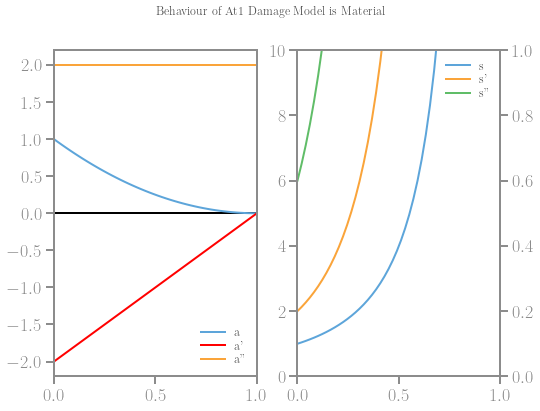

In [687]:
figure, axis = ana.plot_material()

In [688]:
figure.tight_layout()
figure.savefig("../../notes/figures/at1-model.pdf")

In [21]:
# Localised branches
ana._s, ana._sp.simplify(), ana._spp.simplify()

((1 - α(x))**(-2), -2/(α(x) - 1)**3, 6/(α(x) - 1)**4)

<lambdifygenerated-18>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2/(1 - select([greater_equal(t, 1),True], [1.0 - 1/t**2,0], default=nan))**3


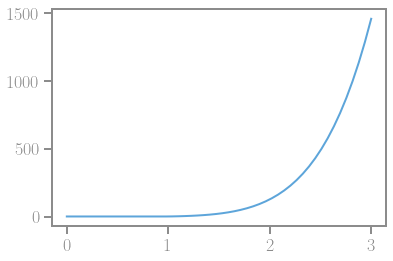

In [21]:
_homog_state, (_uf, _af) = ana._homogeneous_state(_matpar)


_s = ana._sp.subs({α: _homog_state[α]}).subs(_matpar)
_sf = sp.lambdify(t, _s, "numpy")

plt.plot(_times, [_sf(t) for t in _times], c="C0")


$$E_0 H(\sigma, \beta) = 2w(\beta) - \sigma^2 (S(\beta)-S_0))$$

with
$$\eta^2 \alpha'(x)^2 = H(\sigma, \alpha(x)) \qquad \qquad x\in S_i$$

$$e_\text{loc}(\sigma)=\int_0^{\bar \alpha(\sigma)} \frac{S(\beta)-S_0}{\sqrt{2w(\beta) - \sigma^2(S(\beta)-S_0))}}d\beta$$

In [30]:
ana._s

(1 - α(x))**(-2)

In [31]:
sp.diff(ana._s, α) \
    .subs({α: 0})

2

<lambdifygenerated-390>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.9801 - 0.9801/(1 - β)**2
<lambdifygenerated-391>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.814004938271605 - 0.814004938271605/(1 - β)**2
<lambdifygenerated-392>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.66331975308642 - 0.66331975308642/(1 - β)**2
<lambdifygenerated-393>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.528044444444444 - 0.528044444444444/(1 - β)**2
<lambdifygenerated-394>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.408179012345679 - 0.408179012345679/(1 - β)**2
<lambdifygenerated-395>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.303723456790123 - 0.303723456790123/(1 - β)**2
<lambdifygenerated-396>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*β + 0.2146777

(-1.0, 1.0)

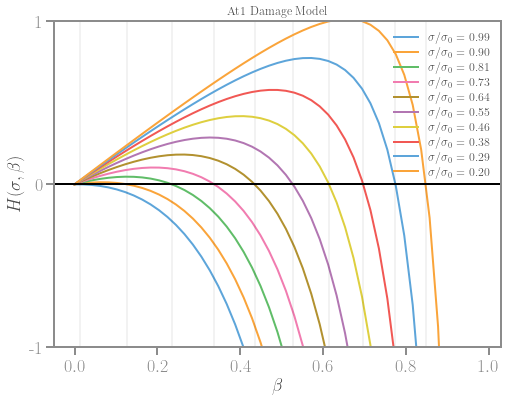

In [689]:
_Hσβ = ana._H_damage_profile().subs(_matpar)

_σ = sp.symbols('σ')
_β = sp.symbols('β')

figure, axis = plt.subplots(1, 1, figsize=(8, 6))


for k in np.linspace(.99, .2, 10):
# for k in np.arange(2, 5):
    _Hβ = _Hσβ.subs({_σ: k})
    # _Hβ = _Hσβ.subs({_σ: 1./k})
    _Hβf = sp.lambdify(_β, _Hβ, "numpy")
    _sol = sp.solve(_Hβ, _β, (0, 1), solver='bisect') 
    αmax = _sol[1][0]
    axis.plot(_damage, [_Hβf(β) for β in _damage], label = f"$\sigma/\sigma_0$  = {k:.2f}")
    # axis.plot(_damage, [_Hβf(β) for β in _damage], label = f"$\sigma/\sigma_0$  = 1/{k:d}")
    axis.axvline(αmax, c='k', lw=.1)



axis.set_ylabel("$H(\\sigma, \\beta)$")
axis.set_xlabel("$\\beta$")
axis.set_title(f"{ana.model}")
axis.legend()
axis.axhline(0, c="k")
axis.set_yticks([-1, 0, 1], ["-1", "0", "1"])
axis.set_ylim(-1, 1)


In [690]:
figure.tight_layout()
figure.savefig("../../notes/figures/at1-Hbeta.pdf")

In [691]:


σv = .5
_β = sp.symbols('β')
_αmax = ana._α_max(σv)


_E0 = ana.model.matpar[E0]
_η = ana.model.matpar[η]

_f = 1/sp.sqrt(ana._H_damage_profile()).subs({_σ: σv}).subs(ana.model.matpar)

# _Dσ =  sp.integrate(_f, (_β, 0, _αmax))
# ana.model.matpar
# _αmax
# 1/_f

(0, _αmax)
_f
# sp.N(_Dσ)

ValueError: 
When a single argument is passed to subs it should be a dictionary of
old: new pairs or an iterable of (old, new) tuples.

In [162]:
_αmax

0.578464834591373

In [154]:
_f = (_η*1/sp.sqrt(ana._H_damage_profile())).subs(ana.model.matpar).subs({_σ: σv, η: .1})
_f

0.05*sqrt(2)/sqrt(β + 0.32 - 0.32/(1 - β)**2)

In [161]:
_f.subs({_β: 0.000001})

577.350413531778*sqrt(2)

In [147]:
_fv = sp.lambdify(_β, _f, "numpy")
_beta = np.linspace(0., np.float64(_αmax), 10)
# _beta
[_fv(b) for b in _beta]

<lambdifygenerated-95>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 0.05*sqrt(2)/sqrt(β + 0.405 - 0.405/(1 - β)**2)


[inf,
 1.4198445928507244,
 1.062902744821545,
 0.9281524075913692,
 0.8716905883783043,
 0.862790575573251,
 0.9000066083189326,
 1.0097065589173468,
 1.3213082406217636,
 inf]

In [148]:

np.trapz([_fv(b) for b in _beta], _beta)

inf

In [48]:

amax = []
for i in np.arange(2, 8):
    amax.append(ana._α_max(1/i))

In [171]:
ana.model.matpar

{n: 1, E0: 1, w1: w1, η: η, L: L}

In [184]:
ana._α_max(.9)

[(0.0, (0.0, 1.0)), (0.129663006415488, (0.0, 1.0)), (1.46533699358451, (0.0, 1.0))]


0.129663006415488

(1 - α(x))**(-2) - 1/E0

In [244]:
def _eps_1_d(sigma):
    _α_max = ana._α_max(sigma)
    _f = (ana._s - 1/E0).subs(α, _β)/sp.sqrt(ana._H_damage_profile())   \
        .simplify()
    # \
            # .subs(ana.model.matpar)         \
            # .subs({_σ: sigma})


    return (_f) 

_integrand = _eps_1_d(.9)

_integrand.subs(ana.model.matpar).simplify()




[(0.0, (0.0, 1.0)), (0.129663006415488, (0.0, 1.0)), (1.46533699358451, (0.0, 1.0))]


(1 - (β - 1)**2)/(sqrt((-σ**2 + (β - 1)**2*(2*β + σ**2))/(β - 1)**2)*(β - 1)**2)

In [246]:
__integrandv = sp.lambdify(_β, _integrand, "numpy")
__integrandv(0.)


Behaviour around $\beta=0$

$$\frac{\partial f}{\partial \beta}|_{\beta=0}$$

with $f = 1/\sqrt{H(\sigma, \beta)}$

In [196]:
sp.diff(_f, _β).simplify().subs({ _β: 0})

E0*(1 - σ**2)/(σ**2*sqrt(-σ**2*(E0 - 1)/E0**2)*(E0 - 1))

In [197]:
sp.diff(_f, _β).simplify().subs({ _β: 0}).subs(ana.model.matpar)

zoo*(1 - σ**2)/σ**2

In [42]:
_σ = sp.symbols('σ')
_β = sp.symbols('β')
sigmav = .8

_f = ((ana._s - 1/E0).subs({α: _β}) * 1/sp.sqrt(ana._H_damage_profile()))    \
    .subs(ana.model.matpar)                                                \
    .subs({_σ: sigmav, η: .1})
_fvβ = sp.lambdify(_β, _f, "numpy")


# _α_max = ana._α_max(sigmav)
# 
print(_α_max.subs(ana.model.matpar))

_x = np.linspace(0.1, .3)
_fvβ(_x)


# np

0.252122461732037


<lambdifygenerated-38>:2: RuntimeWarning: invalid value encountered in sqrt
  return (1/2)*sqrt(2)*(-1 + (1 - β)**(-2.0))/sqrt(β + 0.32 - 0.32/(1 - β)**2)


array([ 1.05031703,  1.09049072,  1.13178395,  1.17430101,  1.21815408,
        1.26346467,  1.31036524,  1.35900097,  1.409532  ,  1.4621359 ,
        1.51701067,  1.57437833,  1.63448927,  1.69762748,  1.76411707,
        1.83433032,  1.90869767,  1.98772056,  2.07198761,  2.16219576,
        2.25917793,  2.36393978,  2.47770953,  2.60200646,  2.73873726,
        2.89033447,  3.05996084,  3.2518203 ,  3.47164825,  3.72751809,
        4.0312376 ,  4.40092493,  4.86615951,  5.47943802,  6.34572512,
        7.7178545 , 10.45474401, 22.97158974,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan])

In [659]:
matpar


{n: 1, E0: 1, w1: 1, η: η}

In [222]:
ana._deps_1_d_dσ()

-2.41839915231229

[(0.0, (0.0, 1.0)), (0.00133296299588935, (0.0, 1.0)), (1.49966653700411, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.143343227067318, (0.0, 1.0)), (1.46139748898206, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.276682482799598, (0.0, 1.0)), (1.41972388139793, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.401636264642337, (0.0, 1.0)), (1.37436017980211, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.518504627966867, (0.0, 1.0)), (1.32500632882326, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.627600938959682, (0.0, 1.0)), (1.27134896227489, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.729250331194344, (0.0, 1.0)), (1.21306294658343, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.823787846649758, (0.0, 1.0)), (1.14981323977000, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.911556295837192, (0.0, 1.0)), (1.08125703132330, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.992903887994099, (0.0, 1.0)), (1.00704611200590, (0.0, 1.0))]


Text(0.5, 1.0, 'At1 Damage Model')

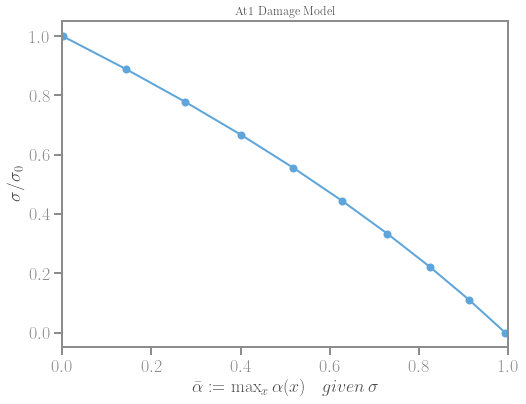

In [692]:

figure, axis = plt.subplots(1, 1, figsize=(8, 6))

amax = []
for i in np.linspace(.999, .01, 10):
    amax.append(ana._α_max(i, matpar))


axis.plot(amax, np.linspace(1, .0, 10), marker='o')
axis.set_xlabel('$\\bar \\alpha := \\max_x \\alpha(x) \\quad given\, \\sigma$')
axis.set_ylabel('$\\sigma/\\sigma_0$')
axis.set_xlim(0., 1.)
axis.set_title(f"{ana.model}")

# plt.plot(np.linspace(-.99, -.2, 10), amax)

In [693]:
figure.tight_layout()
figure.savefig("../../notes/figures/at1-maxalpha.pdf")

In [221]:
- np.pi * 2**(5/2) * (ana._sp**2 / (ana._spp - 2*ana._wpp)**(3/2)).subs({α: 0})
# return - ((np.pi * 2**(5/2) * ((_sp) )**2 * _σc**2 * _E0**1/2) / \
#     (self._spp  * _σc**2 - 2.* self._wpp) ** (3/2)).subs({α: 0})a

-4.83679830462458

## PQ

In [701]:
α

α(x)

In [818]:
state = {u: u, α: α}
p, q, E0, L, w1, η, σc = sp.symbols('p q E0 L w1 η σc')

matpar = {p: p, q: q, E0: E0, L: L, w1: w1, η: η, σc: σc}
_matpar = {p: 1, q: 1, E0: 1, L: 1, w1: 2, η: η, σc: 1}
# _matpar = {n: 1, L: 1, E0: 1, w1: 1, η: η}

dpq = DamagePQ(state, matpar=matpar, name="PQ Damage Model")
ana = ModelAnalysis(model = dpq)
_ = ana.criterion().simplify()
_

-(p + q)*(0.5*E0**2*t**2 - L**2*w1*σc**2)/(E0*L**2)

In [819]:
sp.latex(_)

'- \\frac{\\left(p + q\\right) \\left(0.5 E_{0}^{2} t^{2} - L^{2} w_{1} σc^{2}\\right)}{E_{0} L^{2}}'

In [820]:
_ = ana.model.energy(ana.model.state)
_

0.5*E0*(1 - α(x))**q*Derivative(u(x), x)**2/(α(x) + 1)**p + w1*(η**2*Derivative(α(x), x)**2 + σc**2*(p + q)*α(x)/E0)

In [821]:
sp.latex(_)

'0.5 E_{0} \\left(1 - α{\\left(x \\right)}\\right)^{q} \\left(α{\\left(x \\right)} + 1\\right)^{- p} \\left(\\frac{d}{d x} u{\\left(x \\right)}\\right)^{2} + w_{1} \\left(η^{2} \\left(\\frac{d}{d x} α{\\left(x \\right)}\\right)^{2} + \\frac{σc^{2} \\left(p + q\\right) α{\\left(x \\right)}}{E_{0}}\\right)'

In [822]:
_ = ana.criterion()
_

(p + q)*(-0.5*E0**2*t**2/L**2 + w1*σc**2)/E0

In [823]:
sp.latex(_)

'\\frac{\\left(p + q\\right) \\left(- \\frac{0.5 E_{0}^{2} t^{2}}{L^{2}} + w_{1} σc^{2}\\right)}{E_{0}}'

In [824]:
[np.float(t.subs(_matpar).subs({L: 1})) for t in sp.solve(ana.crit, t)]

/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_86906/972471254.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  [np.float(t.subs(_matpar).subs({L: 1})) for t in sp.solve(ana.crit, t)]


[-2.0, 2.0]

In [825]:
sp.solve(ana.crit, t)[1]

1.4142135623731*L*sqrt(w1)*σc/E0

In [826]:
_matpar

{p: 1, q: 1, E0: 1, L: 1, w1: 2, η: η, σc: 1}

In [827]:
ana.set_critical_load(sp.solve(ana.crit, t)[1])

In [828]:
ana._critical_load

1.4142135623731*L*sqrt(w1)*σc/E0

In [829]:
ana._critical_load.subs(_matpar)

1.4142135623731*sqrt(2)

In [830]:
ana.critical_load_N(_matpar)

2.0

In [831]:
_ = ana.model.energy(ana.model.state)
# , α) \
#     .subs({u: _u0, α: _alpha0})         \
#     .simplify()

In [832]:
sp.latex(_)

'0.5 E_{0} \\left(1 - α{\\left(x \\right)}\\right)^{q} \\left(α{\\left(x \\right)} + 1\\right)^{- p} \\left(\\frac{d}{d x} u{\\left(x \\right)}\\right)^{2} + w_{1} \\left(η^{2} \\left(\\frac{d}{d x} α{\\left(x \\right)}\\right)^{2} + \\frac{σc^{2} \\left(p + q\\right) α{\\left(x \\right)}}{E_{0}}\\right)'

In [833]:
_eq = sp.diff(dpq.energy(state), α) \
    .subs({u: _u0, α: α}) \
    .simplify()

In [834]:
# _ = _eq.subs(_matpar).subs({p: 2, q: 1}).simplify()
_ = _eq.subs(_matpar).simplify()

In [835]:
_matpar

{p: 1, q: 1, E0: 1, L: 1, w1: 2, η: η, σc: 1}

In [836]:
_ah = sp.solve(_, α)


In [837]:
_ah

[-0.5*t - 1.0, 0.5*t - 1.0]

In [839]:
_ = ana._homogeneous_alpha(_matpar)[1]
_

0.5*t - 1.0

In [840]:
sp.latex(_)

'0.5 t - 1.0'

In [841]:
ana.crit
ana.critical_load()

1.4142135623731*L*sqrt(w1)*σc/E0

In [845]:
tc = ana.critical_load().subs(_matpar)


In [847]:
state, (_uf, _af) = ana._homogeneous_state(ah = ana._homogeneous_alpha(_matpar)[1])

1.4142135623731*L*sqrt(w1)*σc/E0


In [848]:
_a = state[α]

_ah_f = sp.lambdify(t, _a.subs(_matpar), "numpy")
_ah_f(0)

array(0.)

In [849]:
print(ana.model)

PQ Damage Model


Text(0.5, 1.0, 'PQ Damage Model')

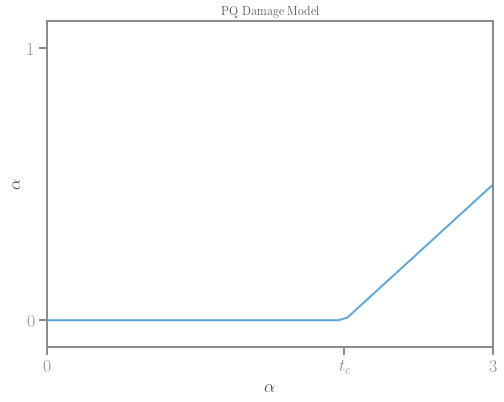

In [853]:
fig, axis = plt.subplots(1, 1, figsize=(8, 6))

axis.plot(_times, [_ah_f(t) for t in _times])
tc = ana.critical_load().subs(_matpar)

# axis.axhline(0, c='k')
axis.set_xlim(0, 3)
axis.set_ylim(-0.1, 1.1)
axis.set_xticks([0, tc, 5], ["0", "$t_c$", "5"])
axis.set_yticks([0, 1], ["0", "1"])
axis.set_xlabel("$\\alpha$")
axis.set_ylabel("$\\alpha$")
axis.set_title(f"{ana.model}")


In [225]:
ana._deps_1_d_dσ()

-8.88576587631673*E0*(p + q)**2/(2*p*q + p*(p - 1) + q*(q + 1))**1.5

In [159]:
ana._deps_1_d_dσ() \
    .subs({E0: 1, σc: 1})

-8.88576587631673*(p + q)**2/(p**3 + 3*p**2*q - 3*p**2 + 3*p*q**2 + 2*p + q**3 + 3*q**2 + 2*q)**1.5

Playground

ATk

In [356]:


state = {u: u, α: α}
_matpar = {k: 2, E0: 1, w1: 1, η: η, L: 1}
matpar = {k: k, E0: 1, w1: w1, η: η, L: L}

_u0 = t*x/L
_alpha0 = 0 

atk = DefaultDamage(state, _matpar)


ana = ModelAnalysis(atk)
_crit = sp.diff(atk.energy(state), α).subs({u: _u0, α: _alpha0}).simplify()
_crit

# atk = DefaultDamage(state, matpar)
ana = ModelAnalysis(atk)
ana.criterion()
ana.set_critical_load(ana.critical_load_N(_matpar)[0][0])
# ana._critical_load
ana._homogeneous_state(ah = ana._homogeneous_alpha()[1])


1


({u(x): t*x/L, α(x): Piecewise((-1.0 + t/(L*sqrt(w1)), t >= 1), (0, True))},
 (<function _lambdifygenerated(t, x)>, <function _lambdifygenerated(t)>))

(0.0, 2.0)

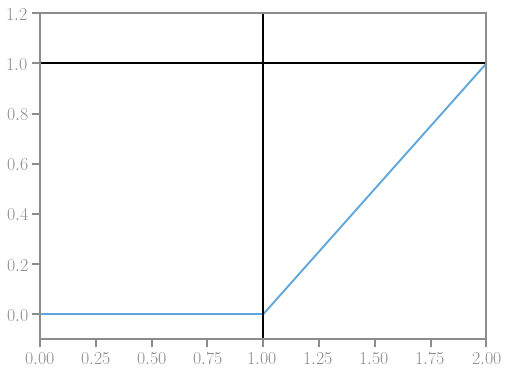

In [357]:

fig, ax = ana.plot_homogeneous_alpha(_matpar)
ax.set_ylim(-0.1, 1.2)
ax.set_xlim(0, _matpar[k])


In [358]:
_stress = ana._stress(ah = ana._homogeneous_alpha()[1]).simplify()


1


In [359]:
_stress.subs(ana.model.matpar)

Piecewise((2.0*sqrt((1 - 0.5*t)**2), t >= 1), (t, True))

(0.0, 2.0)

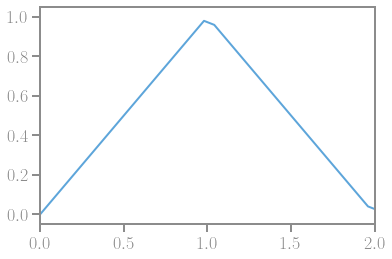

In [360]:
_sh_f = sp.lambdify(t, _stress.subs(ana.model.matpar), "numpy")
plt.plot(_times, [_sh_f(t) for t in _times])
plt.xlim(0, _matpar[k])



<lambdifygenerated-184>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (-_Dummy_4787 - 1)/(_Dummy_4787 - 1)
<lambdifygenerated-185>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2/(_Dummy_4788 - 1)**2
<lambdifygenerated-186>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return -4/(_Dummy_4789 - 1)**3


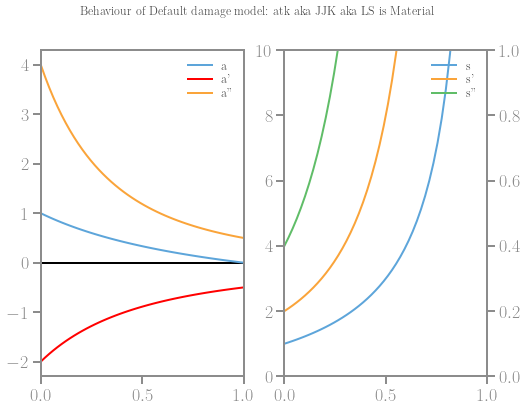

In [361]:
ana.plot_material()

[(0.0, (0.0, 1.0)), (0.00199900000000000, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.209481432098765, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.392812728395062, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.551992888888889, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.687021913580247, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.797899802469136, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.884626555555556, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.947202172839506, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.985626654320988, (0.0, 1.0))]
[(0.0, (0.0, 1.0)), (0.999900000000000, (0.0, 1.0))]


(0.0, 1.0)

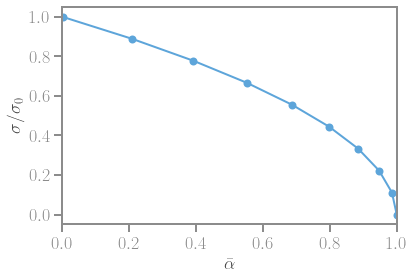

In [362]:



amax = []
for i in np.linspace(.999, .01, 10):
    amax.append(ana._α_max(i))


plt.plot(amax, np.linspace(1, .0, 10), marker='o')
plt.xlabel('$\\bar \\alpha$')
plt.ylabel('$\\sigma/\\sigma_0$')
plt.xlim(0., 1.)
# plt.plot(np.linspace(-.99, -.2, 10), amax)

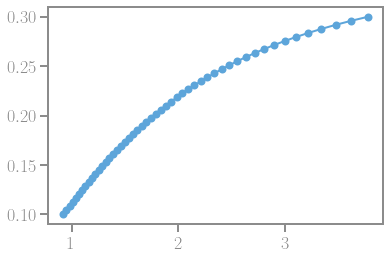

In [363]:
_σ = sp.symbols('σ')
_β = sp.symbols('β')
sigmav = .8

_f = ((ana._s - 1/E0).subs({α: _β}) * 1/sp.sqrt(ana._H_damage_profile()))    \
    .subs(ana.model.matpar)                                                \
    .subs({_σ: sigmav, η: .1})
_fvβ = sp.lambdify(_β, _f, "numpy")


# _α_max = ana._α_max(sigmav)
# 
# print(_α_max.subs(ana.model.matpar))

_x = np.linspace(0.1, .3)
_fvβ(_x)
plt.plot(_fvβ(_x), _x, marker='o')


# np

PQ

In [384]:
p, q, E0, L, w1, η, σc = sp.symbols('p q E0 L w1 η σc')


state = {u: u, α: α}
_matpar = {k: 2, E0: 1, w1: 1, η: η, L: 1, p: 2, q: 2, σc: 1}
matpar = {k: k, E0: 1, w1: w1, η: η, L: L}

_u0 = t*x/L
_alpha0 = 0 

dpq = DamagePQ(state, matpar={}, name="pq")


ana = ModelAnalysis(dpq)
_crit = sp.diff(dpq.energy(state), α).subs({u: _u0, α: _alpha0}).simplify()
_crit

# dpq = DefaultDamage(state, matpar)
ana = ModelAnalysis(dpq)
ana.criterion()
# ana.set_critical_load(ana.critical_load_N(_matpar)[0][0])
# ana._critical_load
# ana._homogeneous_state(ah = ana._homogeneous_alpha()[1])


(p + q)*(-0.5*E0**2*t**2/L**2 + w1*σc**2)/E0

In [385]:
sp.solve(ana.crit, t**2)

[2.0*L**2*w1*σc**2/E0**2]

In [386]:
ana.crit

(p + q)*(-0.5*E0**2*t**2/L**2 + w1*σc**2)/E0

In [367]:
sp.solve(ana.crit, t**2)

[2.0*L**2*w1*σc**2/E0**2]

In [369]:
sp.solve(ana.crit, t**2)

[2.0*L**2*w1*σc**2/E0**2]

In [375]:
ana.model._matpar

{p: p, q: q, E0: E0, w1: w1, η: η, L: L, σc: σc}

In [378]:
_eq = sp.diff(ana.model.energy(state), α) \
                .subs({u: _u0, α: α})         \
                .simplify().subs(_matpar)

_ah = sp.solve(_eq, α)

In [388]:
ana._homogeneous_alpha(matpar = _matpar)

[0.209986841649146*t**2/(-t**2 + (0.0185185185185185*t**6 + t**4)**0.5)**(1/3) - 0.7937005259841*(-t**2 + (0.0185185185185185*t**6 + t**4)**0.5)**(1/3) - 1.0,
 0.209986841649146*t**2*(-0.5 - 0.866025403784439*I)/(-t**2 + (0.0185185185185185*t**6 + t**4)**0.5)**(1/3) - 0.7937005259841*(-0.5 + 0.866025403784439*I)*(-t**2 + (0.0185185185185185*t**6 + t**4)**0.5)**(1/3) - 1.0,
 0.209986841649146*t**2*(-0.5 + 0.866025403784439*I)/(-t**2 + (0.0185185185185185*t**6 + t**4)**0.5)**(1/3) - 0.7937005259841*(-0.5 - 0.866025403784439*I)*(-t**2 + (0.0185185185185185*t**6 + t**4)**0.5)**(1/3) - 1.0]

In [389]:
_u0

t*x/L

<lambdifygenerated-203>:2: RuntimeWarning: invalid value encountered in double_scalars
  return 0.209986841649146*t**2/(-t**2 + sqrt(0.0185185185185185*t**6 + t**4))**(1/3) - 0.7937005259841*(-t**2 + sqrt(0.0185185185185185*t**6 + t**4))**(1/3) - 1.0
<lambdifygenerated-204>:2: RuntimeWarning: invalid value encountered in cdouble_scalars
  return 0.209986841649146*t**2*(-0.5 - 0.866025403784439*1j)/(-t**2 + sqrt(0.0185185185185185*t**6 + t**4))**(1/3) - 0.7937005259841*(-0.5 + 0.866025403784439*1j)*(-t**2 + sqrt(0.0185185185185185*t**6 + t**4))**(1/3) - 1.0
/opt/homebrew/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
<lambdifygenerated-205>:2: RuntimeWarning: invalid value encountered in cdouble_scalars
  return 0.209986841649146*t**2*(-0.5 + 0.866025403784439*1j)/(-t**2 + sqrt(0.0185185185185185*t**6 + t**4))**(1/3) - 0.7937005259841*(-0.5 - 0.866025403784439*1j)*(-t

(0.0, 2.0)

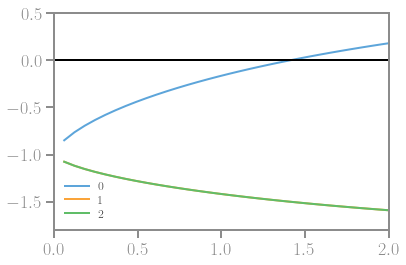

In [395]:
_eq = sp.diff(dpq.energy(state), α) \
    .subs({u: _u0, α: α}) \
    .simplify().subs(_matpar)

_ah = sp.solve(_eq, α)


_ah_f = [sp.lambdify(t, a.subs(_matpar), "numpy") for a in _ah]

# _ahp = sp.lambdify(t, _ah_sub[0].subs(_matpar), "numpy")

_times = np.linspace(0., 3)

for _i, _a in enumerate(_ah_f):
    plt.plot(_times, [_a(t) for t in _times], label=_i)
plt.legend()

plt.axhline(0, c='k')
plt.xlim(0, _matpar[k])
# plt.plot()

In [397]:
ana._homogeneous_state(ah = ana._homogeneous_alpha(matpar = _matpar)[0])


AttributeError: 'ModelAnalysis' object has no attribute '_critical_load'

In [400]:
ana.critical_load_N(_matpar)[0][0]

1

In [402]:
ana.critical_load()

[2.0*L**2*w1*σc**2/E0**2]